In [15]:
%pip install gdown
import gdown

url = "https://drive.google.com/drive/folders/1_z2a2W9ZmOhjz9FeNhn5GftGC-G-31N9?usp=sharing"
gdown.download_folder(url, quiet=True)

['/content/biometric_systems_project/dataset.zip']

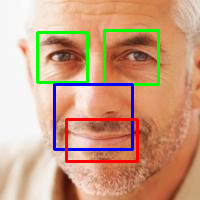

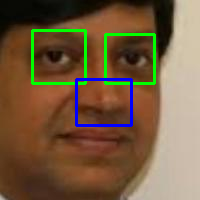

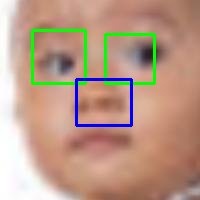

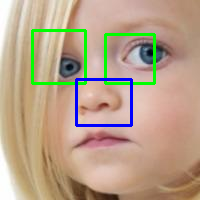

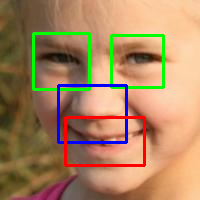

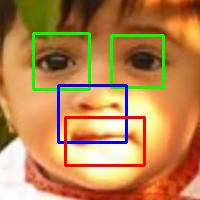

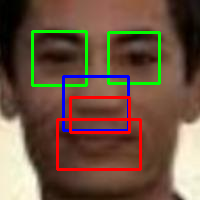

KeyboardInterrupt: 

In [18]:
import zipfile
import os
import cv2
import shutil
import numpy as np
from google.colab.patches import cv2_imshow

def main():
  def update_dictionary(key, dictionary, file_name):
    if key not in dictionary:
      dictionary[key] = {file_name}
    else:
      dictionary[key].add(file_name)

  # folder containing the zip files and the one that will contains the images extracted from those files
  folder_path = "/content/biometric_systems_project"
  for file_name in os.listdir(folder_path):

    # zipped files in the folder biometric_systems_dataset
    if file_name.endswith(".zip"):

      # full path to the zip file
      file_path = os.path.join(folder_path, file_name)

      # create folder in the same path with the name of the zip file
      extract_folder = os.path.join(folder_path, file_name.replace(".zip", ""))
      os.makedirs(extract_folder, exist_ok=True)

      # open and extract the file
      with zipfile.ZipFile(file_path, mode="r") as zip_ref:
        zip_ref.extractall(extract_folder)

        for root, _, files in os.walk(extract_folder):
          for image_file in files:
            if image_file.lower().endswith('.jpg'):
              source_file = os.path.join(root, image_file)
              destination_file = os.path.join(folder_path, image_file)

              # move the image file to the destination path
              shutil.move(source_file, destination_file)

        # remove the extracted folder and all its contents
        shutil.rmtree(extract_folder)
        os.remove(extract_folder + ".zip")

  ages, genders, ethnicities = dict(), dict(), dict()
  for file_name in os.listdir(folder_path):

    # rename pictures that start with "._"
    if(file_name[0] != "h"):
      if (file_name[0] == "."):
        file_name = file_name[2:]
      else:
        age, gender, ethnicity, _ = file_name.split("_")
        update_dictionary(age, ages, file_name)
        update_dictionary(gender, genders, file_name)
        update_dictionary(ethnicity, ethnicities, file_name)


  face_cascade_path = "/content/biometric_systems_project/haarcascade_frontalface_default.xml"
  eye_cascade_path = "/content/biometric_systems_project/haarcascade_eye.xml"
  nose_cascade_path = "/content/biometric_systems_project/haarcascade_mcs_nose.xml"
  mouth_cascade_path = "/content/biometric_systems_project/haarcascade_mcs_mouth.xml"

  face_cascade = cv2.CascadeClassifier(face_cascade_path)
  eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
  nose_cascade = cv2.CascadeClassifier(nose_cascade_path)
  mouth_cascade = cv2.CascadeClassifier(mouth_cascade_path)

  # Controlla se ciascun file di cascata è stato caricato correttamente
  if face_cascade.empty():
      print("Errore: il file haarcascade_frontalface_default.xml non è stato trovato o caricato correttamente.")
      return
  if eye_cascade.empty():
      print("Errore: il file haarcascade_eye.xml non è stato trovato o caricato correttamente.")
      return
  if nose_cascade.empty():
      print("Errore: il file haarcascade_mcs_nose.xml non è stato trovato o caricato correttamente.")
      return
  if mouth_cascade.empty():
      print("Errore: il file haarcascade_mcs_mouth.xml non è stato trovato o caricato correttamente.")
      return


  for file_name in os.listdir(folder_path):
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    if image is None:
        continue  # Salta se l'immagine non può essere letta

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Seleziona il primo volto trovato
    for (x, y, w, h) in faces:
        face_roi = gray_image[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(face_roi)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 255, 0), 2)

    # Rilevamento del naso
    noses = nose_cascade.detectMultiScale(face_roi, scaleFactor=1.1, minNeighbors=5)
    for (nx, ny, nw, nh) in noses:
        cv2.rectangle(image, (x+nx, y+ny), (x+nx+nw, y+ny+nh), (255, 0, 0), 2)

    # Rilevamento della bocca
    mouths = mouth_cascade.detectMultiScale(face_roi, scaleFactor=1.1, minNeighbors=5)
    for (mx, my, mw, mh) in mouths:
        # Filtra per le bocche in basso nel volto (approssimazione)
        if my > h // 2:
            cv2.rectangle(image, (x+mx, y+my), (x+mx+mw, y+my+mh), (0, 0, 255), 2)

    cv2_imshow(image)  # Usa cv2_imshow per Colab
    cv2.waitKey(500)

if __name__ == "__main__":
  main()